In [30]:
import pandas as pd
from utils.data_prep_utils import *
from transformers.encoder import *
from transformers.binner import *
from transformers.standardizer import *
from model_binclass import dt_binclass

In [31]:
#Data import form drive
df = pd.read_csv(r'resources/Machine failure.csv')
df = df.drop(['TWF','HDF','PWF', 'OSF', 'RNF'], axis=1)

target_col = df.columns[-1]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 703.3+ KB


In [32]:
df = df.drop(['UDI', 'Product ID'], axis=1)
features = df.columns.drop(target_col)

df = data_split_stratified(df, target_col,  0.2)

encoder_info = learn_encoder(df[df.dataset==0])
df = apply_encoder(df, encoder_info)
target_col = 'remainder__Machine failure'

stand_info = learn_standardizer(df[df.remainder__dataset==0])
df = apply_standardizer(df, stand_info)

print(f"y_train - 0: {sum((df['remainder__dataset'] == 1) & (df[target_col] == 0))}, 1: {sum((df['remainder__dataset'] == 1) & (df[target_col] == 1))}")
print(f"y_test  - 0: {sum((df['remainder__dataset'] == 0) & (df[target_col] == 0))}, 1: {sum((df['remainder__dataset'] == 0) & (df[target_col] == 1))}")

y_train - 0: 7729, 1: 271
y_test  - 0: 1932, 1: 68


In [12]:
#XGBoost
model_info = xgboost_binclass.learn_model(df[df.remainder__dataset == 1], target_col)
df = xgboost_binclass.apply_model(df, target_col, model_info)

print("Prediction Evaluation:")
xgboost_binclass.evaluate_model(df, target_col)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 26]

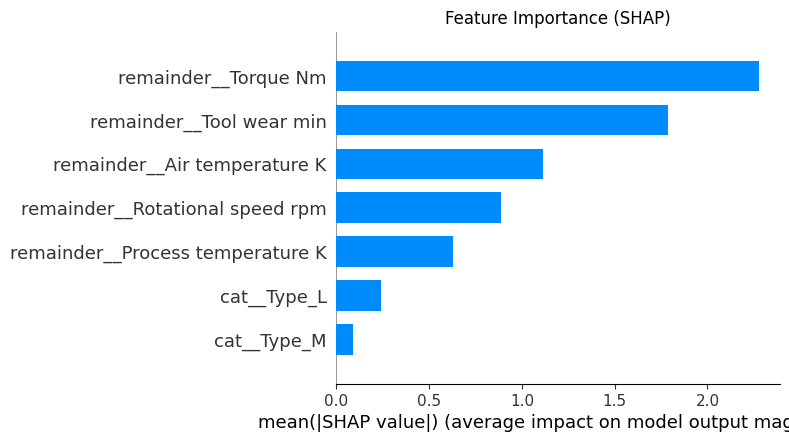

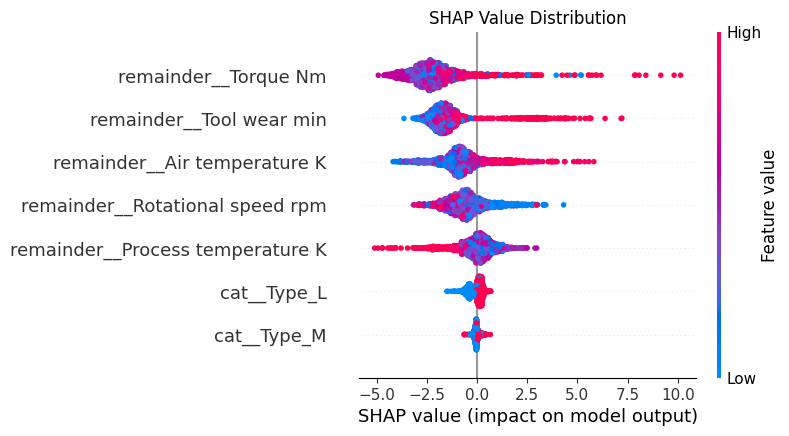

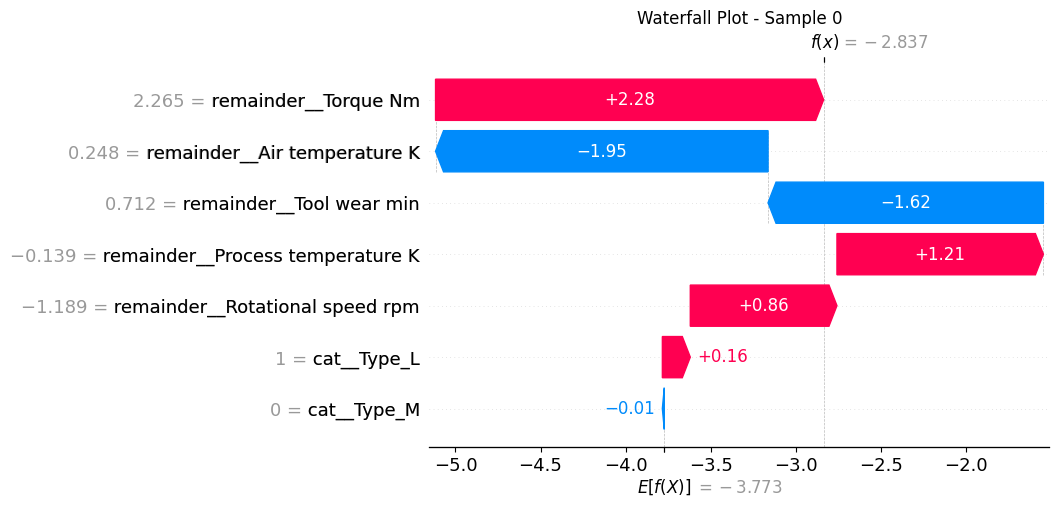

Decision plot could not be generated: decision() missing 1 required positional argument: 'shap_values'


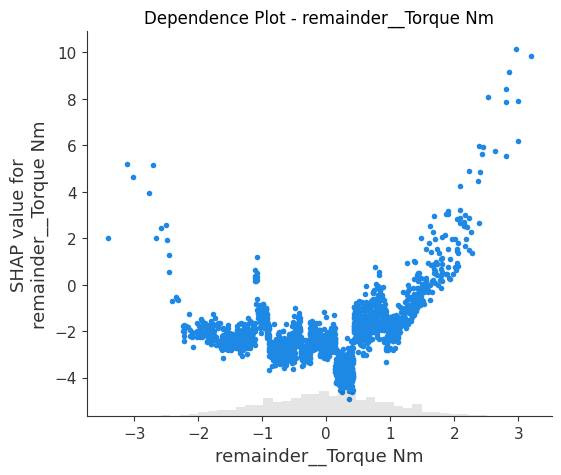

In [ ]:
xgboost_binclass.explain_model(model_info, df[features], index_feature = False)

In [ ]:
save_encoder(encoder_info, filepath="resources/info/encoder_info.joblib")
save_standardizer(stand_info, filepath="resources/info/stand_info.joblib")
xgboost_binclass.save_model(model_info, filepath="resources/info/model_info.joblib")

Encoder saved to encoder_info
Standardizer saved to stand_info
Model saved to model_info
